# Preprocessing Workflow

This is meant as a very simple example for a preprocessing workflow. In this workflow we will conduct the following steps:

1. Motion correction of functional images with FSL's MCFLIRT
2. Coregistration of functional images to anatomical images (according to FSL's FEAT pipeline)
3. Smoothing of coregistrated functional images with FWHM set to 4mm and 8mm
4. Artifact Detection in functional images (to detect outlier volumes)

In [ ]:
%%bash
export SPM_PATH=/auto/k1/arash/spm12/
export PATH=/auto/k1/arash/anaconda3/bin:$PATH
export PATH=$PATH:/usr/share/fsl/5.0/bin;
export FSLDIR=/usr/share/fsl;
export LD_LIBRARY_PATH=/usr/lib/fsl/5.0;
. ${FSLDIR}/5.0/etc/fslconf/fsl.sh;
export FSLOUTPUTTYPE=NIFTI;

## Imports

First, let's import all modules we later will be needing.

In [ ]:
%pylab inline
from os.path import join as opj
from nipype.interfaces.fsl import MCFLIRT, FLIRT
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node

# Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [ ]:
experiment_dir = '/auto/data/arash/output'
output_dir = 'datasink'
working_dir = 'workingdir'
base_directory = '/auto/data/arash/data/ds000105'

# list of subject identifiers
subject_list = ['sub-1']


# list of session identifiers
task_list = ['objectviewing']


# list of session identifiers
session_list = ['run-01']
#                 'run-02',
#                 'run-03', 'run-04', 'run-05',
#                 'run-06', 'run-07', 'run-08', 'run-09', 'run-10',
#                 'run-11', 'run-12']

# TR of functional images
TR = 2.0

# Smoothing withds used during preprocessing
fwhm = [4]


## Specify Nodes for the main workflow

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [ ]:
# MCFLIRT - motion correction
# mcflirt = Node(MCFLIRT(mean_vol=True,
#                        save_plots=True,
#                        output_type='NIFTI'),
#                name="mcflirt")


# FLIRT - coregister functional images to anatomical images
coreg_step1 = Node(FLIRT(output_type='NIFTI'), name="coreg_step1")
coreg_step2 = Node(FLIRT(output_type='NIFTI',
                         apply_xfm=True), name="coreg_step2")

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [ ]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'session_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('session_id', session_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('{subject_id}', 'anat', '{subject_id}_T1w.nii.gz')
func_file = opj('{subject_id}', 'func',
                '{subject_id}_task-objectviewing_{session_id}_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory=base_directory),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id', ''),
                 ('_session_id_', ''),
                 ('_task-flanker', ''),
                 ('_mcf.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
subjFolders = [('%s_%s/' % (sess, sub), '%s/%s' % (sub, sess))
               for sess in session_list
               for sub in subject_list]
subjFolders += [('%s_%s' % (sub, sess), '')
                for sess in session_list
                for sub in subject_list]
subjFolders += [('%s%s_' % (sess, sub), '')
                for sess in session_list
                for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [ ]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('session_id', 'session_id')]),
                 (selectfiles, mcflirt, [('func', 'in_file')]),

                 (mcflirt, coreg_step1, [('mean_img', 'in_file')]),
                 (selectfiles, coreg_step1, [('anat', 'reference')]),

                 (mcflirt, coreg_step2, [('out_file', 'in_file')]),
                 (selectfiles, coreg_step2, [('anat', 'reference')]),
                 (coreg_step1, coreg_step2, [('out_matrix_file',
                                              'in_matrix_file')]),

                 (coreg_step2, smooth, [('out_file', 'in_files')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (selectfiles, datasink, [('anat', 'preproc.@resample')]),
                 (coreg_step1, datasink, [('out_file', 'preproc.@coregmean')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                 ])

## Visualize the workflow

It always helps to visualize your workflow.

In [ ]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.dot.png'))

In [ ]:
# Visualize the detailed graph
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.dot.png'))

##  Run the Workflow

Now that everything is ready, we can run the preprocessing workflow. Change ``n_procs`` to the number of jobs/cores you want to use. **Note** that if  you're using a Docker container and FLIRT fails to run without any good reason, you might need to change memory settings in the Docker preferences (6 GB should be enough for this workflow).

In [ ]:
preproc.run('MultiProc', plugin_args={'n_procs': 20})

# !/auto/k1/arash/anaconda2/bin/nipypecli crash /auto/k1/arash/EEE485/Codes/crash-20171202-215020-arash-mcflirt.b1-5cb61df0-9ba1-4683-81bd-4a92f92a3059.pklz

# Example 2: 1st-level Analysis

In this example we will take the preprocessed output from the first example and run for each subject a 1st-level analysis. For this we need to do the following steps:

1. Extract onset times of stimuli from TVA file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts

In the previous example, we used two different smoothing kernels of fwhm=4 and fwhm=8. Therefore, let us also run the 1st-level analysis for those two versions.

**So, let's begin!**

# Imports

First, we need to import all modules we later want to use.

In [1]:
%pylab inline
from os.path import join as opj
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node

Populating the interactive namespace from numpy and matplotlib


# Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [55]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

# Specify GLM contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate. If we recap, we had two different conditions in this dataset:

- **congruent** - Flanker stimuli: ``< < < < <``
- **incongruent** - Flanker stimuli: ``< < > < <``

Therefore, we could create the following contrasts:

In [56]:
# Condition names
condition_names = ['scissors', 'face', 'cat', 'shoe', 'house', 'scrambledpix', 'bottle', 'chair']

# Contrasts
# cont01 = ['average',        'T', condition_names, [0.5, 0.5]]
cont02 = ['face',      'T', condition_names, [0, 1, 0, 0, 0, 0, 0, 0]]
# cont03 = ['incongruent',    'T', condition_names, [0, 1]]
# cont04 = ['cong > incong',  'T', condition_names, [1, -1]]
# cont05 = ['incong > cong',  'T', condition_names, [-1, 1]]

# cont06 = ['activation',     'F', [cont02, cont03]]
# cont07 = ['differences',    'F', [cont04, cont05]]

# contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07]
contrast_list = [cont02]

# Specify GLM Model

The next step is now to get information such as stimuli onset, duration and other regressors into the GLM model. For this we need to create a helper function, in our case called ``subjectinfo``.

To recap, let's see what we have in the TSV file for each run:

In [57]:
!cat ./ds000105/sub-1/func/sub-1_task-objectviewing_run-02_events.tsv

onset	duration	trial_type
12.000	0.500	face
14.000	0.500	face
16.000	0.500	face
18.000	0.500	face
20.000	0.500	face
22.000	0.500	face
24.000	0.500	face
26.000	0.500	face
28.000	0.500	face
30.000	0.500	face
32.000	0.500	face
34.000	0.500	face
48.000	0.500	cat
50.000	0.500	cat
52.000	0.500	cat
54.000	0.500	cat
56.000	0.500	cat
58.000	0.500	cat
60.000	0.500	cat
62.000	0.500	cat
64.000	0.500	cat
66.000	0.500	cat
68.000	0.500	cat
70.000	0.500	cat
84.000	0.500	shoe
86.000	0.500	shoe
88.000	0.500	shoe
90.000	0.500	shoe
92.000	0.500	shoe
94.000	0.500	shoe
96.000	0.500	shoe
98.000	0.500	shoe
100.000	0.500	shoe
102.000	0.500	shoe
104.000	0.500	shoe
106.000	0.500	shoe
120.000	0.500	chair
122.000	0.500	chair
124.000	0.500	chair
126.000	0.500	chair
128.000	0.500	chair
130.000	0.500	chair
132.000	0.500	chair
134.000	0.500	chair
136.000	0.500	chair
138.000	0.500	chair
140.000	0.500	chair
142.000	0.500	chair
156.000	0.500	scissors
158.000	0.500	scissors
160.000	0.500	scissors
162.000	0.500	scissors
16

So what we need is the onset and the stimuli type, i.e. **column 0** and **column 5 or 7**.

In [58]:
filename = './ds000105/sub-1/func/sub-1_task-objectviewing_run-01_events.tsv'
trailinfo = np.genfromtxt(filename, delimiter='\t', dtype=None, skip_header=1)
trailinfo = [[t[0], t[2]] for t in trailinfo]
trailinfo

[[12.0, b'scissors'],
 [14.0, b'scissors'],
 [16.0, b'scissors'],
 [18.0, b'scissors'],
 [20.0, b'scissors'],
 [22.0, b'scissors'],
 [24.0, b'scissors'],
 [26.0, b'scissors'],
 [28.0, b'scissors'],
 [30.0, b'scissors'],
 [32.0, b'scissors'],
 [34.0, b'scissors'],
 [48.0, b'face'],
 [50.0, b'face'],
 [52.0, b'face'],
 [54.0, b'face'],
 [56.0, b'face'],
 [58.0, b'face'],
 [60.0, b'face'],
 [62.0, b'face'],
 [64.0, b'face'],
 [66.0, b'face'],
 [68.0, b'face'],
 [70.0, b'face'],
 [84.0, b'cat'],
 [86.0, b'cat'],
 [88.0, b'cat'],
 [90.0, b'cat'],
 [92.0, b'cat'],
 [94.0, b'cat'],
 [96.0, b'cat'],
 [98.0, b'cat'],
 [100.0, b'cat'],
 [102.0, b'cat'],
 [104.0, b'cat'],
 [106.0, b'cat'],
 [120.0, b'shoe'],
 [122.0, b'shoe'],
 [124.0, b'shoe'],
 [126.0, b'shoe'],
 [128.0, b'shoe'],
 [130.0, b'shoe'],
 [132.0, b'shoe'],
 [134.0, b'shoe'],
 [136.0, b'shoe'],
 [138.0, b'shoe'],
 [140.0, b'shoe'],
 [142.0, b'shoe'],
 [156.0, b'house'],
 [158.0, b'house'],
 [160.0, b'house'],
 [162.0, b'house'],
 [16

And finally we need to separate the onsets of the two stimuli. This can be done as follows:

In [59]:
onset1 = []
onset2 = []
onset3 = []
onset4 = []
onset5 = []
onset6 = []
onset7 = []
onset8 = []

for t in trailinfo:
    if b'scissors' in t[1]:
        onset1.append(t[0])
    if b'face' in t[1]:
        onset2.append(t[0])
    if b'cat' in t[1]:
        onset3.append(t[0])
    if b'shoe' in t[1]:
        onset4.append(t[0])
    if b'house' in t[1]:
        onset5.append(t[0])
    if b'scrambledpix' in t[1]:
        onset6.append(t[0])
    if b'bottle' in t[1]:
        onset7.append(t[0])
    else:
        onset8.append(t[0])

print(onset1)
print(onset2)
print(onset3)
print(onset4)
print(onset5)
print(onset6)
print(onset7)
print(onset8)

[12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0]
[48.0, 50.0, 52.0, 54.0, 56.0, 58.0, 60.0, 62.0, 64.0, 66.0, 68.0, 70.0]
[84.0, 86.0, 88.0, 90.0, 92.0, 94.0, 96.0, 98.0, 100.0, 102.0, 104.0, 106.0]
[120.0, 122.0, 124.0, 126.0, 128.0, 130.0, 132.0, 134.0, 136.0, 138.0, 140.0, 142.0]
[156.0, 158.0, 160.0, 162.0, 164.0, 166.0, 168.0, 170.0, 172.0, 174.0, 176.0, 178.0]
[192.0, 194.0, 196.0, 198.0, 200.0, 202.0, 204.0, 206.0, 208.0, 210.0, 212.0, 214.0]
[228.0, 230.0, 232.0, 234.0, 236.0, 238.0, 240.0, 242.0, 244.0, 246.0, 248.0, 250.0]
[12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 48.0, 50.0, 52.0, 54.0, 56.0, 58.0, 60.0, 62.0, 64.0, 66.0, 68.0, 70.0, 84.0, 86.0, 88.0, 90.0, 92.0, 94.0, 96.0, 98.0, 100.0, 102.0, 104.0, 106.0, 120.0, 122.0, 124.0, 126.0, 128.0, 130.0, 132.0, 134.0, 136.0, 138.0, 140.0, 142.0, 156.0, 158.0, 160.0, 162.0, 164.0, 166.0, 168.0, 170.0, 172.0, 174.0, 176.0, 178.0, 192.0, 194.0, 196.0, 198.0, 200.0, 202.0, 204.0,

Now, let us incorporate all this in the helper function subjectinfo.

In [61]:
def subjectinfo(subject_id):

    import numpy as np
    from os.path import join as opj
    from nipype.interfaces.base import Bunch

    condition_names = ['scissors', 'face', 'cat', 'shoe', 'house', 'scrambledpix', 'bottle', 'chair']

    logfile_dir = opj('/data', 'ds000105', subject_id, 'func')

    for sess in ['run-01', 'run-02', 'run-03', 'run-04',
                 'run-05', 'run-06', 'run-07', 'run-08',
                 'run-09', 'run-10', 'run-11', 'run-12']:

        # Read the TSV file
        filename = opj(logfile_dir,
                       '%s_task-objectviewing_%s_events.tsv' % (subject_id, sess))

        # Save relevant information
        trailinfo = np.genfromtxt(filename, delimiter='\t',
                                  dtype=None, skip_header=1)
        trailinfo = [[t[0], t[2]] for t in trailinfo]

        # Separate onset of conditions
        onset1 = []
        onset2 = []
        onset3 = []
        onset4 = []
        onset5 = []
        onset6 = []
        onset7 = []
        onset8 = []

        for t in trailinfo:
            if b'scissors' in t[1]:
                onset1.append(t[0])
            if b'face' in t[1]:
                onset2.append(t[0])
            if b'cat' in t[1]:
                onset3.append(t[0])
            if b'shoe' in t[1]:
                onset4.append(t[0])
            if b'house' in t[1]:
                onset5.append(t[0])
            if b'scrambledpix' in t[1]:
                onset6.append(t[0])
            if b'bottle' in t[1]:
                onset7.append(t[0])
            else:
                onset8.append(t[0])

        # Save values per session
        onsets = [onset1, onset2, onset3, onset4, onset5, onset6, onset7, onset8]
        if sess == 'run-01':
            run1 = onsets
        elif sess == 'run-02':
            run2 = onsets
        elif sess == 'run-03':
            run3 = onsets
        elif sess == 'run-04':
            run4 = onsets
        elif sess == 'run-05':
            run5 = onsets
        elif sess == 'run-06':
            run6 = onsets
        elif sess == 'run-07':
            run7 = onsets
        elif sess == 'run-08':
            run8 = onsets
        elif sess == 'run-09':
            run9 = onsets
        elif sess == 'run-10':
            run10 = onsets
        elif sess == 'run-11':
            run11 = onsets
        elif sess == 'run-12':
            run12 = onsets

    subjectinfo = []
    for r in range(12):
        if r == 0:
            onsetTimes = run1
        elif r == 1:
            onsetTimes = run2
        elif r == 2:
            onsetTimes = run3
        elif r == 3:
            onsetTimes = run4
        elif r == 4:
            onsetTimes = run5
        elif r == 5:
            onsetTimes = run6
        elif r == 6:
            onsetTimes = run7
        elif r == 7:
            onsetTimes = run8
        elif r == 8:
            onsetTimes = run9
        elif r == 9:
            onsetTimes = run9
        elif r == 10:
            onsetTimes = run10
        elif r == 11:
            onsetTimes = run11
        elif r == 12:
            onsetTimes = run12
            
        subjectinfo.insert(r,
                       Bunch(conditions=condition_names,
                             onsets=onsetTimes,
                             durations=[[0.5], [0.5], [0.5], [0.5], [0.5], [0.5], [0.5], [0.5]],
                             amplitudes=None,
                             tmod=None,
                             pmod=None,
                             regressor_names=None,
                             regressors=None))

    return subjectinfo  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

# Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [62]:


# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', '{subject_id}',
                         'run-*_fwhm_{fwhm_id}', 's_bold_mcf_flirt.nii'),
             'mc_param': opj(output_dir, 'preproc', '{subject_id}',
                             'run-*_bold_mcf.par')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [63]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param',
                                               'realignment_parameters')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file',
                                               '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

## Visualize the workflow

It always helps to visualize your workflow.

171202-15:16:51,796 workflow INFO:
	 Generated workflow graph: /output/workingdir/l1analysis/graph.dot.png (graph2use=colored, simple_form=True).


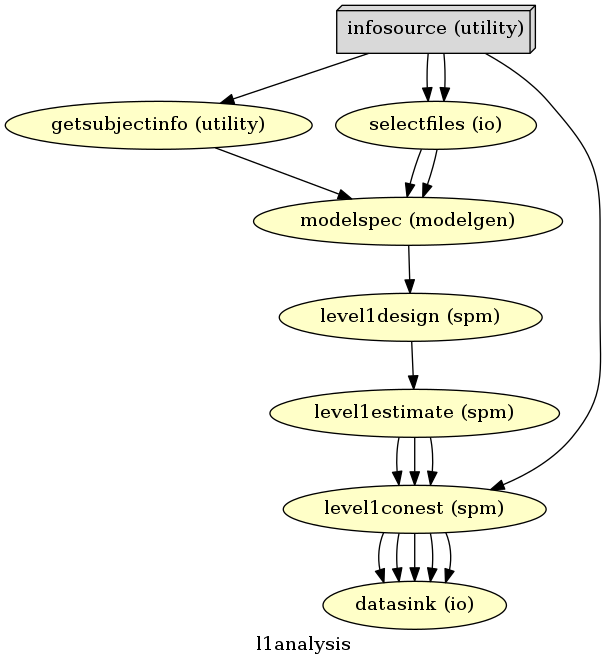

In [64]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.dot.png'))

##  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [24]:
# l1analysis.run()

!nipypecli crash /home/neuro/nipype_tutorial/crash-20171202-152205-neuro-selectfiles.a1-bf392c9d-cff8-415a-8259-222070927eba.pklz

/bin/sh: 1: nipypecli: not found
